# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


C:\ProgramData\Anaconda3\envs\drl\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\drl\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



C:\ProgramData\Anaconda3\envs\drl\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


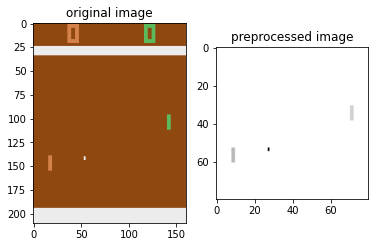

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        self.conv1 = nn.Conv2d(2, 4, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5, stride=2, padding=2)
        self.size = 16*20*20
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
        # flatten the tensor
        x = x.view(-1, self.size)
        x = self.fc1(x)
        x = self.sig(self.fc2(x))
        return x

# use your own policy!
policy=Policy().to(device)

# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 1e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"b
# to see what the agent sees

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

C:\ProgramData\Anaconda3\envs\drl\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\drl\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [7]:
import numpy as np

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    old_probs = torch.tensor(np.array(old_probs), dtype=torch.float, device=device)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float, device=device)
    
    discounts = torch.pow(discount, torch.arange(rewards.shape[0])).to(device)
    rewards_future = torch.cumsum(rewards.flip((0,)), axis=0).flip((0,))
#     print(discounts)
#     print(rewards_future)
    
    m = torch.mean(rewards_future, axis=1).reshape(-1, 1)
    std = torch.std(rewards_future, axis=1).reshape(-1, 1) + 1.e-10
    
    rewards_future = (rewards_future - m) / std
    
#     print(rewards_future)

    rewards_future *= discounts.reshape(-1, 1)
    
#     print(rewards_future)
    
    actions = torch.tensor(np.array(actions), dtype=torch.int8, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    rewards = torch.min((rewards_future * new_probs / old_probs).sum(axis=0), 
                        torch.clamp((rewards_future * new_probs / old_probs).sum(axis=0), 1 - epsilon, 1 + epsilon))
    
#     print(rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs * torch.log(old_probs + 1.e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1.e-10))

    return torch.mean(rewards) + torch.mean(beta*entropy)


Lsur = clipped_surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(-21.4339, device='cuda:0', grad_fn=<AddBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [8]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -14.500000
[-14. -15. -12. -16. -14. -16. -16. -13.]


Episode: 40, score: -14.500000
[-13. -15. -16. -11. -16. -16. -14. -15.]


Episode: 60, score: -15.000000
[-13. -13. -16. -15. -16. -16. -15. -16.]


Episode: 80, score: -13.125000
[-17.  -8. -12. -16. -15. -10. -11. -16.]


Episode: 100, score: -13.500000
[-14. -13. -15. -14. -13. -16. -15.  -8.]


Episode: 120, score: -11.125000
[-11. -12. -12. -10. -10. -11.  -8. -15.]


Episode: 140, score: -6.125000
[ -9.  -6.  -7.  -6.  -5.  -3. -10.  -3.]


Episode: 160, score: -6.375000
[ -7.  -9.  -7.  -3.  -6. -10.  -4.  -5.]


Episode: 180, score: -2.750000
[-1. -2. -1. -1. -2. -1. -7. -7.]


Episode: 200, score: -2.000000
[-1. -3. -3.  1. -1. -2. -5. -2.]


Episode: 220, score: -0.750000
[ 0.  1. -4.  0. -3. -1.  0.  1.]


Episode: 240, score: -0.125000
[ 0.  3.  1. -2.  0.  0. -2. -1.]


Episode: 260, score: 1.000000
[ 2.  3.  0.  3. -1.  0. -2.  3.]


Episode: 280, score: 1.750000
[-1.  0.  3.  3.  3.  5. -2.  3.]


Episode: 300, score: 3.000000
[ 5.  3.  0.  3.  5.  5.  5. -2.]


Episode: 320, score: 2.750000
[ 3.  5. -2.  3.  4.  5.  0.  4.]


Episode: 340, score: 3.625000
[3. 5. 5. 5. 3. 5. 0. 3.]


Episode: 360, score: 4.125000
[ 5.  5.  5.  5.  5.  5.  5. -2.]


Episode: 380, score: 4.750000
[3. 5. 5. 5. 5. 5. 5. 5.]


Episode: 400, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 420, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 440, score: 4.250000
[5. 5. 5. 5. 5. 0. 5. 4.]


Episode: 460, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 480, score: 4.250000
[5. 3. 5. 5. 1. 5. 5. 5.]


Episode: 500, score: 4.375000
[5. 5. 5. 5. 5. 5. 0. 5.]


In [9]:
pong_utils.play(env, policy, time=200) 

In [10]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 